## Predictive models for NFL games to enable spread betting.

### Load packages and data files

In [16]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error, accuracy_score, r2_score
from sklearn.preprocessing import StandardScaler
from scipy.stats.mstats import winsorize

In [17]:
# regression model packages
import xgboost as xgb
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.dummy import DummyRegressor

## Model and basic feature evaluation

In [18]:
# Function to train the model
def train_model(model, X_train, y_train):
    model.fit(X_train, y_train)
    return model

scaler = StandardScaler()

In [19]:
def plot_heatmap(results, values='MSE'):
    """
    Creates and plots a heatmap of the mean values of a specified column 
    with Model as rows and Feature_Set as columns.

    Parameters:
    results (DataFrame): The input DataFrame containing the data.
    values (str): The name of the column to use for the values in the pivot table (default is 'MSE').

    Returns:
    None
    """
    # Create crosstab with Model as rows, Feature_Set as columns, and mean of the specified values
    crosstab_df = pd.pivot_table(results, values=values, index='Model', columns='Feature_Set', aggfunc='mean')

    # Plot heatmap with gradient color scale (red to yellow to green)
    plt.figure(figsize=(8, 6))
    sns.heatmap(crosstab_df, cmap='RdYlGn_r', annot=True, fmt=".2f", linewidths=0.5, cbar_kws={'label': values}, annot_kws={"size": 8})

    # Add title to the heatmap
    plt.title(f'Average {values} by Model and Feature_Set')

    # Display the heatmap
    plt.show()


In [20]:
#import data
merged_df = pd.read_csv('../data/nfl_games_pfr_features.csv')
print(merged_df.columns)

#Separate played and upcoming games
merged_played = merged_df[~merged_df['Margin Yds'].isna()]
merged_upcoming = merged_df[merged_df['Margin Yds'].isna()]

Index(['Unnamed: 0', 'Day', 'Date', 'Time', 'Winner', 'LoserIsHome', 'Loser',
       'PtsW', 'PtsL', 'YdsW', 'TOW', 'YdsL', 'TOL', 'season', 'week',
       'Winner Abbr', 'Loser Abbr', 'Home Team', 'Away Team', 'Home Score',
       'Away Score', 'Winner Yds', 'Loser Yds', 'Margin Yds', 'Winner TO',
       'Loser TO', 'Margin TO', 'Margin Pts', 'Total Pts', 'Margin Pct',
       'home_team_winner', 'away_win_bonus', 'DateTime',
       'DaysSinceLastGame_Home', 'DaysSinceLastGame_Away', 'Home_DefenseRank',
       'Home_OffenseRank', 'Home_ScoreRank', 'Week', 'Away_DefenseRank',
       'Away_OffenseRank', 'Away_ScoreRank', 'Spread', 'Delta_OffenseRank',
       'Ratio_OffenseRank', 'Delta_DefenseRank', 'Ratio_DefenseRank',
       'Delta_ScoreRank', 'Ratio_ScoreRank', 'intTerm1', 'intTerm2',
       'intTerm3', 'intTerm4', 'quadTerm1', 'quadTerm2', 'quadTerm3',
       'quadTerm4', 'HomeStrength', 'AwayStrength', 'Home_Impact',
       'Away_Impact', 'Impact', 'ImpactNeg', 'Differential_Home',


C:\Users\see_w\AppData\Roaming\Python\Python313\site-packages\scipy\stats\_continuous_distns.py:801: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  a, b = optimize.fsolve(func, (1.0, 1.0))


  Distribution                                         Parameters  \
2      lognorm  (0.10457304226734666, -86.5885928454542, 131.4...   
4         beta  (43.4470649820562, 118962197.45873773, -45.729...   
3        gamma  (43.44708823817326, -45.72973313191946, 2.1026...   
6  weibull_max  (5.8314967795832215, 116.31175259590427, 76.24...   
7            t  (22.572384309412612, 45.45051334293125, 13.244...   
5  weibull_min  (2.715740758328588, 10.848200109318887, 39.177...   
0         norm             (45.62321428571428, 13.87308533856923)   
8      uniform                                       (3.0, 102.0)   
1        expon                           (3.0, 42.62321428571428)   

   KS Statistic        P-Value  
2      0.028309   5.413572e-02  
4      0.029235   4.261150e-02  
3      0.029235   4.261142e-02  
6      0.032107   1.930910e-02  
7      0.038657   2.408109e-03  
5      0.039347   1.890638e-03  
0      0.045149   2.091291e-04  
8      0.311800  5.761868e-194  
1      0.358

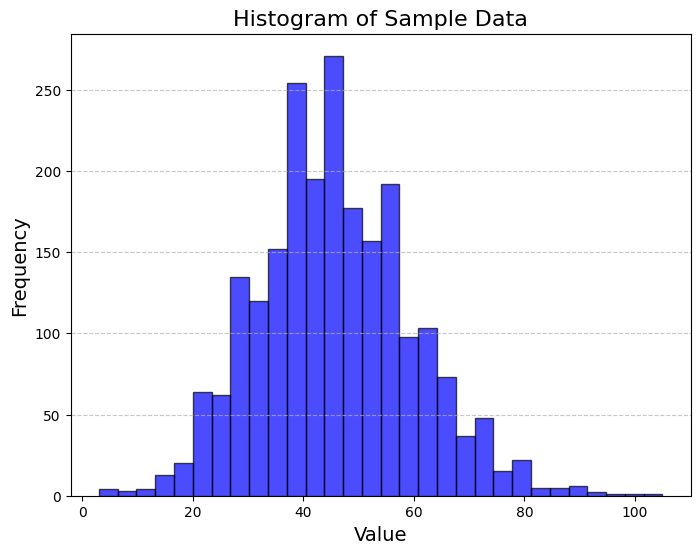

In [21]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt

def determine_best_distribution(data):
    """
    Determines the best distribution for a given dataset.
    
    Parameters:
        data (array-like): The dataset to analyze.
    
    Returns:
        pd.DataFrame: DataFrame containing distribution names, parameters, KS statistic, and p-value.
    """
    # List of distributions to check
    distributions = [
        stats.norm, stats.expon, stats.lognorm, stats.gamma, stats.beta,
        stats.weibull_min, stats.weibull_max, stats.t, stats.uniform
    ]
    
    results = []
    for dist in distributions:
        try:
            # Fit the distribution to data
            params = dist.fit(data)
            
            # Perform the KS test
            ks_stat, p_value = stats.kstest(data, dist.name, args=params)
            
            # Store the results
            results.append({
                'Distribution': dist.name,
                'Parameters': params,
                'KS Statistic': ks_stat,
                'P-Value': p_value
            })
        except Exception as e:
            # Catch exceptions for distributions that fail
            results.append({
                'Distribution': dist.name,
                'Parameters': None,
                'KS Statistic': np.nan,
                'P-Value': np.nan,
                'Error': str(e)
            })
    
    # Convert results to a DataFrame and sort by KS Statistic (lower is better)
    results_df = pd.DataFrame(results).sort_values(by='KS Statistic')
    return results_df

# Example usage
filtered_played = merged_played[merged_played['Delta_ScoreRank'].abs() >= 0.000]
sample_data = filtered_played['Total Pts']
    
# Determine the best distribution
best_dist = determine_best_distribution(sample_data)
print(best_dist)

# Create the histogram
plt.figure(figsize=(8, 6))
plt.hist(sample_data, bins=30, alpha=0.7, color='blue', edgecolor='black')

# Add labels and title
plt.title('Histogram of Sample Data', fontsize=16)
plt.xlabel('Value', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

# Display the plot
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [22]:
# Define features and target

filtered_played = merged_played[merged_played['Delta_ScoreRank'].abs() >= 0.000]

feature_sets = [
    ('1A.1', filtered_played[['Home_ScoreRank', 'Away_ScoreRank']]), 
    ('1B.1', filtered_played[['Delta_ScoreRank']]),
    ('1C.1', filtered_played[['Ratio_ScoreRank']]),
    ('2A.1', filtered_played[['Home_OffenseRank', 'Home_DefenseRank', 'Home_ScoreRank', 'Away_OffenseRank', 'Away_DefenseRank', 'Away_ScoreRank']]),
    ('2B.1', filtered_played[['Delta_ScoreRank', 'Delta_OffenseRank', 'Delta_DefenseRank']]),
    ('2C.1', filtered_played[['Ratio_ScoreRank', 'Ratio_OffenseRank', 'Ratio_DefenseRank']]),
    ('3A.1', filtered_played[['Home_OffenseRank', 'Home_DefenseRank', 'Away_OffenseRank', 'Away_DefenseRank']]),
    ('3B.1', filtered_played[['Delta_OffenseRank', 'Delta_DefenseRank']]),
    ('3C.1', filtered_played[['Ratio_OffenseRank', 'Ratio_DefenseRank']]),
    ('4A.1', filtered_played[['Home_OffenseRank', 'Home_DefenseRank', 'Home_ScoreRank', 'Away_OffenseRank', 'Away_DefenseRank', 'Away_ScoreRank',  
                              'intTerm1', 'intTerm2', 'intTerm3', 'intTerm4', 'quadTerm1', 'quadTerm2', 'quadTerm3', 'quadTerm4', 
                              'DaysSinceLastGame_Home', 'DaysSinceLastGame_Away', 'HomeStrength', 'AwayStrength','Home_Impact','Away_Impact', 'Impact',
                              'Differential_Home', 'Differential_Away', 'Differential']]),
    ('4B.1', filtered_played[['Delta_ScoreRank', 'Delta_OffenseRank', 'Delta_DefenseRank',  
                              'intTerm1', 'intTerm2', 'intTerm3', 'intTerm4', 'quadTerm1', 'quadTerm2', 'quadTerm3', 'quadTerm4', 
                              'DaysSinceLastGame_Home', 'DaysSinceLastGame_Away', 'HomeStrength', 'AwayStrength','Home_Impact','Away_Impact', 'Impact',
                              'Differential_Home', 'Differential_Away', 'Differential']]),
    ('4C.1', filtered_played[['Ratio_ScoreRank', 'Ratio_OffenseRank', 'Ratio_DefenseRank', 
                              'intTerm1', 'intTerm2', 'intTerm3', 'intTerm4', 'quadTerm1', 'quadTerm2', 'quadTerm3', 'quadTerm4', 
                              'DaysSinceLastGame_Home', 'DaysSinceLastGame_Away', 'HomeStrength', 'AwayStrength','Home_Impact','Away_Impact', 'Impact',
                              'Differential_Home', 'Differential_Away', 'Differential']]),
    ('5A.1', filtered_played[['Delta_ScoreRank', 'Delta_OffenseRank', 'Delta_DefenseRank',  
                              'intTerm1', 'intTerm2']]),
    ('5B.1', filtered_played[['Delta_ScoreRank', 'Delta_OffenseRank', 'Delta_DefenseRank',  
                              'Impact']]),
    ('5C.1', filtered_played[['Delta_ScoreRank', 'Delta_OffenseRank', 'Delta_DefenseRank', 
                              'Differential']]),
    ('5D.1', filtered_played[['Delta_ScoreRank', 'Delta_OffenseRank', 'Delta_DefenseRank', 
                              'intTerm1', 'intTerm2', 'Impact',
                              'Differential']]),
    ('5E.1', filtered_played[['Delta_ScoreRank', 'Delta_OffenseRank', 'Delta_DefenseRank', 
                              'Impact','Differential']]),
    ]

#y = np.log(filtered_played['Total Pts'])
y = filtered_played['Spread']

# Define models
models = [
    ('LM', LinearRegression()),
    ('LMnoINT', LinearRegression(fit_intercept=False)),
    ('Ridge0.01', Ridge(alpha=0.01)),
    ('Ridge0.1', Ridge(alpha=0.1)),
    ('Ridge1.0', Ridge(alpha=1.0)),  # You can tune the alpha parameter
    ('XGBoostBase', xgb.XGBRegressor(objective='reg:squarederror', n_estimators=50, learning_rate=0.1, max_depth=3, random_state=42)),
    ('XGBoost150', xgb.XGBRegressor(objective='reg:squarederror', n_estimators=150, learning_rate=0.1, max_depth=3, random_state=42)),
    ('XGBoost5', xgb.XGBRegressor(objective='reg:squarederror', n_estimators=50, learning_rate=0.1, max_depth=5, random_state=42)),
    ('XGBoost0.5', xgb.XGBRegressor(objective='reg:squarederror', n_estimators=50, learning_rate=0.05, max_depth=3, random_state=42)),
    ('RF50', RandomForestRegressor(n_estimators=50, max_depth=3, random_state=42)),
    ('RF10', RandomForestRegressor(n_estimators=10, max_depth=3, random_state=42)),
    ('SVM', SVR(kernel='rbf', C=1.0, epsilon=0.1)),
    ('SVMlin', SVR(kernel='linear', C=1.0, epsilon=0.1)),
    ('kNN10', KNeighborsRegressor(n_neighbors=10)),
    ('kNN20', KNeighborsRegressor(n_neighbors=20)),
    ('BaselineAvg', DummyRegressor(strategy='mean'))
]

for feature_name, feature_data in feature_sets:
    num_rows = feature_data.shape[0]  # Get the number of rows
    print(f"Feature Set {feature_name}: {num_rows} rows")

print("DONE")

Feature Set 1A.1: 2240 rows
Feature Set 1B.1: 2240 rows
Feature Set 1C.1: 2240 rows
Feature Set 2A.1: 2240 rows
Feature Set 2B.1: 2240 rows
Feature Set 2C.1: 2240 rows
Feature Set 3A.1: 2240 rows
Feature Set 3B.1: 2240 rows
Feature Set 3C.1: 2240 rows
Feature Set 4A.1: 2240 rows
Feature Set 4B.1: 2240 rows
Feature Set 4C.1: 2240 rows
Feature Set 5A.1: 2240 rows
Feature Set 5B.1: 2240 rows
Feature Set 5C.1: 2240 rows
Feature Set 5D.1: 2240 rows
Feature Set 5E.1: 2240 rows
DONE


In [24]:
# DataFrame to store results
results = pd.DataFrame(columns=['Model', 'Feature_Set', 'Fold', 'MSE', 'Accuracy'])

# Define cross-validation strategy (5 folds in this case)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Iterate over feature sets and models
for i, (feature_name, X) in enumerate(feature_sets):
    for model_name, model in models:
        print(f"Evaluating model: {model_name} with feature set {feature_name}")
        
        fold_number = 1
        # Cross-validation loop
        for train_index, test_index in kf.split(X):
            # Use iloc to select rows by integer index
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
            
            # Train the model
            model = train_model(model, X_train, y_train)

            # Make predictions on the test set
            y_pred = model.predict(X_test)

            # Evaluate the model
            mse = mean_squared_error(y_test, y_pred)
            
            # Calculate accuracy of predicting the winner
            y_pred_winner = ['Home' if pred > 0 else 'Away' for pred in y_pred]
            y_test_winner = ['Home' if actual > 0 else 'Away' for actual in y_test]
            accuracy = accuracy_score(y_test_winner, y_pred_winner)
            
            # Store the results for each fold
            new_result = pd.DataFrame({
                'Model': [model_name],
                'Feature_Set': [feature_name],
                'Fold': [fold_number],
                'MSE': [mse*100],
                'Accuracy': [accuracy * 100]
            })
            results = pd.concat([results, new_result], ignore_index=True)
            
            fold_number += 1

# Print the results DataFrame
#print(results)

Evaluating model: LM with feature set 1A.1
Evaluating model: LMnoINT with feature set 1A.1
Evaluating model: Ridge0.01 with feature set 1A.1
Evaluating model: Ridge0.1 with feature set 1A.1
Evaluating model: Ridge1.0 with feature set 1A.1
Evaluating model: XGBoostBase with feature set 1A.1
Evaluating model: XGBoost150 with feature set 1A.1


C:\Users\see_w\AppData\Local\Temp\ipykernel_20760\3247085377.py:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, new_result], ignore_index=True)


Evaluating model: XGBoost5 with feature set 1A.1
Evaluating model: XGBoost0.5 with feature set 1A.1
Evaluating model: RF50 with feature set 1A.1
Evaluating model: RF10 with feature set 1A.1
Evaluating model: SVM with feature set 1A.1
Evaluating model: SVMlin with feature set 1A.1
Evaluating model: kNN10 with feature set 1A.1
Evaluating model: kNN20 with feature set 1A.1
Evaluating model: BaselineAvg with feature set 1A.1
Evaluating model: LM with feature set 1B.1
Evaluating model: LMnoINT with feature set 1B.1
Evaluating model: Ridge0.01 with feature set 1B.1
Evaluating model: Ridge0.1 with feature set 1B.1
Evaluating model: Ridge1.0 with feature set 1B.1
Evaluating model: XGBoostBase with feature set 1B.1
Evaluating model: XGBoost150 with feature set 1B.1
Evaluating model: XGBoost5 with feature set 1B.1
Evaluating model: XGBoost0.5 with feature set 1B.1
Evaluating model: RF50 with feature set 1B.1
Evaluating model: RF10 with feature set 1B.1
Evaluating model: SVM with feature set 1B.1

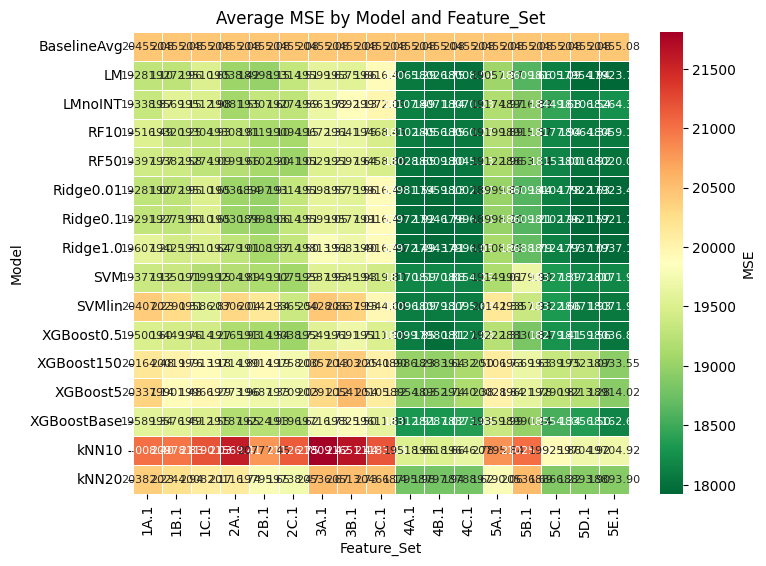

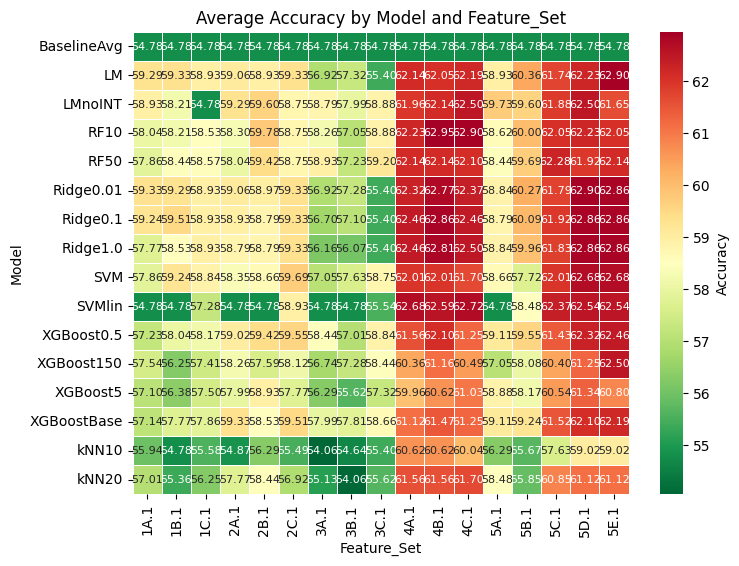

In [25]:
plot_heatmap(results, values='MSE')
plot_heatmap(results, values='Accuracy')

## Optimize the best model and feature set

Models: Random Forest, SVM, XGBoost  


In [39]:
filtered_played = merged_played[merged_played['Delta_ScoreRank'].abs() > 0.0000]
X = filtered_played[['Delta_ScoreRank', 'Delta_OffenseRank', 'Delta_DefenseRank','Impact', 'Differential']]
y = filtered_played['Spread']

#X = sm.add_constant(X)
    
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=17)


model = RandomForestRegressor(n_estimators=50, max_depth=3, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Random Forest MSE: {mse}")

# Extract feature importance
importance = model.feature_importances_

# Create a DataFrame to rank the features
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display top features
print(feature_importance_df)

# Initialize RFE with RandomForest as the estimator
rfe = RFE(estimator=model, n_features_to_select=10)  # Select top 10 features

# Fit RFE
rfe.fit(X_train, y_train)

# Get the ranking of features
ranking = rfe.ranking_

# Identify the selected features
selected_features = X_train.columns[rfe.support_]
print(f'Selected features: {selected_features}')

# Retrain the model with just the top features
X_train_top = X_train[selected_features]
X_test_top = X_test[selected_features]

rf_model_top = RandomForestRegressor(n_estimators=50, max_depth=3, random_state=42)
rf_model_top.fit(X_train_top, y_train)

# Evaluate the model with the top features
y_pred_top = rf_model_top.predict(X_test_top)
mse_top = mean_squared_error(y_test, y_pred_top)
print(f'Mean Squared Error with top features: {mse_top}')



Random Forest MSE: 156.82495514011458
             Feature  Importance
4       Differential    0.762298
3             Impact    0.110856
1  Delta_OffenseRank    0.050396
2  Delta_DefenseRank    0.038976
0    Delta_ScoreRank    0.037474
Selected features: Index(['Delta_ScoreRank', 'Delta_OffenseRank', 'Delta_DefenseRank', 'Impact',
       'Differential'],
      dtype='object')
Mean Squared Error with top features: 156.82495514011458


C:\Users\see_w\AppData\Roaming\Python\Python313\site-packages\sklearn\feature_selection\_rfe.py:300: UserWarning: Found n_features_to_select=10 > n_features=5. There will be no feature selection and all features will be kept.
  warnings.warn(


In [40]:
filtered_played = merged_played[merged_played['Delta_ScoreRank'].abs() > 0.0000]
X = filtered_played[['Delta_ScoreRank', 'Delta_OffenseRank', 'Delta_DefenseRank','Impact', 'Differential']]
y = filtered_played['Spread']

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=17)

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

# Define your Random Forest model
rf = RandomForestRegressor()

# Create the hyperparameter grid
param_grid = {
    'n_estimators': [10, 50, 100, 250],
    'max_depth': [2, 3, 5, 7, 9],
    'min_samples_split': [2, 5, 10, 25],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2',4]
}

# Perform randomized search
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=param_grid, 
                               n_iter=25, cv=5, random_state=42, n_jobs=-1, scoring='neg_mean_squared_error')

# Fit the model
rf_random.fit(X_train, y_train)

# Print the best parameters
print("Best parameters found: ", rf_random.best_params_)
best_rf = rf_random.best_estimator_

y_pred = best_rf.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error (MSE):", mse)


Best parameters found:  {'n_estimators': 50, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 3}
Mean Squared Error (MSE): 158.04343415556363


In [41]:
filtered_played = merged_played[merged_played['Delta_ScoreRank'].abs() > 0.0000]
X = filtered_played[['Delta_ScoreRank', 'Delta_OffenseRank', 'Delta_DefenseRank','Impact', 'Differential']]
y = filtered_played['Spread']

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=17)

from sklearn.linear_model import Ridge
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error

# Define your Random Forest model
ridge_model = Ridge()

# Create the hyperparameter grid
param_grid = {
    'alpha': [0.01, 0.1, 1, 10, 50, 100, 200],  # Regularization strength
    'fit_intercept': [True, False],  # Whether to fit the intercept term
    'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']  # Different solvers for optimization
}

# Perform randomized search
ridge_random = RandomizedSearchCV(estimator=ridge_model, param_distributions=param_grid,
                                  n_iter=25, cv=5, random_state=42, n_jobs=-1, scoring='neg_mean_squared_error')

# Fit the model
ridge_random.fit(X_train, y_train)

# Print the best parameters
print("Best parameters found: ", ridge_random.best_params_)
best_ridge = ridge_random.best_estimator_

y_pred = best_ridge.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error (MSE):", mse)


Best parameters found:  {'solver': 'sparse_cg', 'fit_intercept': True, 'alpha': 0.1}
Mean Squared Error (MSE): 154.4930765704624


In [42]:
# Define your XGBoost model
xgb_model = xgb.XGBRegressor()

# Create the hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2, 0.5],
    'min_child_weight': [1, 3, 5]
}

# Perform randomized search
xgb_random = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_grid,
                                n_iter=25, cv=5, random_state=42, n_jobs=-1, scoring='neg_mean_squared_error')

# Fit the model
xgb_random.fit(X_train, y_train)

# Print the best parameters
print("Best parameters found: ", xgb_random.best_params_)
best_xgb = xgb_random.best_estimator_

# Make predictions and evaluate the model
y_pred = best_xgb.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error (MSE):", mse)


Best parameters found:  {'subsample': 0.8, 'n_estimators': 200, 'min_child_weight': 1, 'max_depth': 3, 'learning_rate': 0.01, 'gamma': 0.1, 'colsample_bytree': 1.0}
Mean Squared Error (MSE): 157.90790951383704


### Models

Best model parameters:  
RF: 'n_estimators': 50, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 3
SVM: {'C': 100, 'degree': 2, 'epsilon': 10, 'gamma': 'scale', 'kernel': 'linear'}
XGB: {'subsample': 0.8, 'n_estimators': 200, 'min_child_weight': 1, 'max_depth': 3, 'learning_rate': 0.01, 'gamma': 0.1, 'colsample_bytree': 1.0}
Ridge: {'solver': 'sparse_cg', 'fit_intercept': True, 'alpha': 0.1}


In [43]:
# Define features and target

filtered_played = merged_played[merged_played['Delta_ScoreRank'].abs() > 0.000]

X = filtered_played[['Delta_ScoreRank', 'Delta_OffenseRank', 'Delta_DefenseRank','Home_Impact','Away_Impact', 'Differential_Home', 'Differential_Away']]

target_sets = [
    filtered_played['Spread'],
    filtered_played['Spread'].clip(-15,15),
    pd.Series(winsorize(filtered_played['Spread'], limits=[0.05, 0.05])),
    pd.Series(winsorize(filtered_played['Spread'], limits=[0.1, 0.1]))
]

# Define models
models = [
    ('LM', LinearRegression()),
    ('RF', RandomForestRegressor(n_estimators=500, max_depth=3, min_samples_split=5,min_samples_leaf=2,max_features='log2')),
    ('Ridge', Ridge(solver='sparse_cg', fit_intercept=True, alpha=0.1)),
    ('XGB', xgb.XGBRegressor(n_estimators=200, learning_rate=0.01, max_depth=3, gamma=0.1, subsample=0.8, colsample_bytree=1.0, min_child_weight=1)),
    ('BaselineAvg', DummyRegressor(strategy='mean'))
]

print("DONE")

DONE


In [44]:
# DataFrame to store results
results = pd.DataFrame(columns=['Model', 'Feature_Set', 'Fold', 'MSE', 'Accuracy'])

# Define cross-validation strategy (5 folds in this case)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Iterate over feature sets and models
for i, y in enumerate(target_sets):
    for model_name, model in models:
        print(f"Evaluating model: {model_name} with target set {i+1}")
        
        fold_number = 1
        # Cross-validation loop
        for train_index, test_index in kf.split(y):
            # Use iloc to select rows by integer index
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
            
            # Train the model
            model = train_model(model, X_train, y_train)

            # Make predictions on the test set
            y_pred = model.predict(X_test)

            # Evaluate the model
            mse = mean_squared_error(y_test, y_pred)
            
            # Calculate accuracy of predicting the winner
            y_pred_winner = ['Home' if pred > 0 else 'Away' for pred in y_pred]
            y_test_winner = ['Home' if actual > 0 else 'Away' for actual in y_test]
            accuracy = accuracy_score(y_test_winner, y_pred_winner)
            
            # Store the results for each fold
            new_result = pd.DataFrame({
                'Model': [model_name],
                'Feature_Set': [f'Set {i+1}'],
                'Fold': [fold_number],
                'MSE': [mse],
                'Accuracy': [accuracy * 100]
            })
            results = pd.concat([results, new_result], ignore_index=True)
            
            fold_number += 1

# Print the results DataFrame
#print(results)

Evaluating model: LM with target set 1
Evaluating model: RF with target set 1


C:\Users\see_w\AppData\Local\Temp\ipykernel_20760\3829972947.py:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, new_result], ignore_index=True)


Evaluating model: Ridge with target set 1
Evaluating model: XGB with target set 1
Evaluating model: BaselineAvg with target set 1
Evaluating model: LM with target set 2
Evaluating model: RF with target set 2
Evaluating model: Ridge with target set 2
Evaluating model: XGB with target set 2
Evaluating model: BaselineAvg with target set 2
Evaluating model: LM with target set 3
Evaluating model: RF with target set 3
Evaluating model: Ridge with target set 3
Evaluating model: XGB with target set 3
Evaluating model: BaselineAvg with target set 3
Evaluating model: LM with target set 4
Evaluating model: RF with target set 4
Evaluating model: Ridge with target set 4
Evaluating model: XGB with target set 4
Evaluating model: BaselineAvg with target set 4


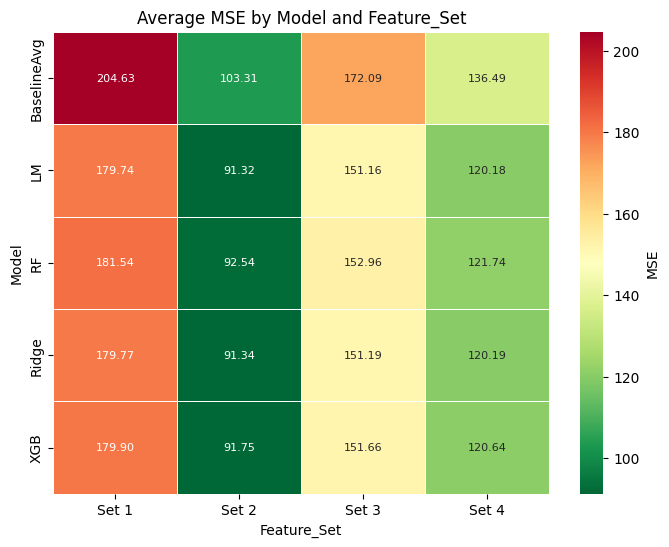

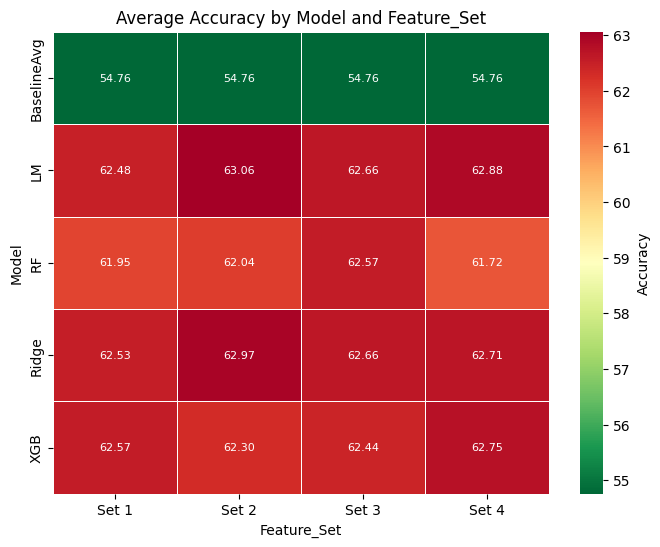

In [45]:
plot_heatmap(results, values='MSE')
plot_heatmap(results, values='Accuracy')

## Make next weeks predictions

In [46]:
filtered_played = merged_played[merged_played['Delta_ScoreRank'].abs() > 0.000]

feature_columns = [
    'Delta_ScoreRank', 'Delta_OffenseRank', 'Delta_DefenseRank','Impact', 'Differential'
]


""" feature_columns = ['Home_OffenseRank', 'Home_DefenseRank', 'Home_ScoreRank', 'Away_OffenseRank', 'Away_DefenseRank', 'Away_ScoreRank',  
                              'intTerm1', 'intTerm2', 'intTerm3', 'intTerm4', 'quadTerm1', 'quadTerm2', 'quadTerm3', 'quadTerm4', 
                              'DaysSinceLastGame_Home', 'DaysSinceLastGame_Away', 'HomeStrength', 'AwayStrength','Home_Impact','Away_Impact', 'Impact',
                              'Differential_Home', 'Differential_Away', 'Differential'] """


# Select features and target variable
X = filtered_played[feature_columns]
y = filtered_played['Spread']
#y = np.log(filtered_played['Total Pts'])

# Define the model
model = LinearRegression()

# Fit the model
model.fit(X, y)

# Prepare the data for upcoming games
X_new = merged_upcoming[feature_columns]

# Predict the spread for upcoming games
y_pred_new = model.predict(X_new)

# Assign predictions to the merged_upcoming DataFrame (using .loc to avoid SettingWithCopyWarning)
merged_upcoming = merged_upcoming.assign(Predicted_Spread=y_pred_new)

# Save predictions to an Excel file

print(merged_upcoming[['Week','Home Team', 'Away Team', 'Delta_ScoreRank', 'Predicted_Spread']].to_csv('predictions.csv', index=False))

# Print the selected columns
print(merged_upcoming[['Week','Home Team', 'Away Team', 'Delta_ScoreRank', 'Predicted_Spread']])

None
    Week Home Team Away Team  Delta_ScoreRank  Predicted_Spread
0    3.0       BUF       MIA          0.04045         13.599575
1    3.0       CAR       ATL         -0.01653         -8.205514
2    3.0       MIN       CIN         -0.02379         -4.455917
3    3.0       TEN       IND         -0.03102         -4.028781
4    3.0       CLE        GB         -0.05253        -13.483412
5    3.0       JAC       HOU          0.01104          2.321637
6    3.0        TB       NYJ          0.03075         11.852572
7    3.0        NE       PIT          0.00156          6.900309
8    3.0       WAS        LV         -0.00481          2.916292
9    3.0       PHI       LAR          0.00018         -0.896038
10   3.0       LAC       DEN          0.03412          7.801574
11   3.0       SEA        NO          0.01628          7.342260
12   3.0        SF       ARI          0.02313          7.922193
13   3.0       CHI       DAL         -0.00263        -11.326485
14   3.0       NYG        KC       

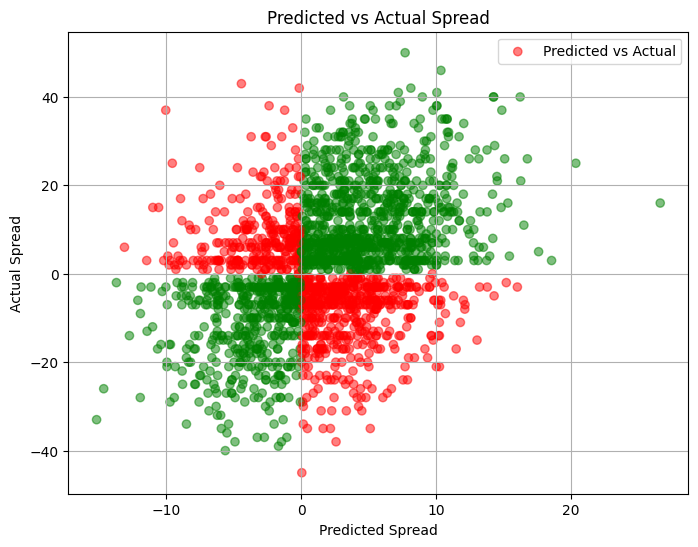

In [47]:
y_pred_fit = model.predict(X)


colors = np.where((y > 0) & (y_pred_fit > 0) | (y < 0) & (y_pred_fit < 0), 'green', 'red')

# Assuming y_pred_fit is already predicted and y contains actual values
plt.figure(figsize=(8, 6))
plt.scatter(y_pred_fit, y, alpha=0.5, c=colors, label='Predicted vs Actual')
plt.xlabel('Predicted Spread')
plt.ylabel('Actual Spread')
plt.title('Predicted vs Actual Spread')
plt.legend()
plt.grid(True)
plt.show()


In [48]:
filtered_played[['Delta_ScoreRank', 'Delta_OffenseRank', 'Delta_DefenseRank','Impact', 'Differential', 'season','week']].describe()

,Delta_ScoreRank,Delta_OffenseRank,Delta_DefenseRank,Impact,Differential,season,week
count,2239.000000,2239.000000,2239.000000,2239.000000,2239.000000,2239.000000,2239.000000
mean,0.000002,-0.000645,-0.000067,-0.000885,-0.250668,2019.497544,10.078607
std,0.031427,0.032388,0.027253,14.141744,11.033148,2.873544,4.404288
min,-0.123450,-0.211130,-0.154880,-49.500000,-42.500000,2015.000000,3.000000
25%,-0.016645,-0.015820,-0.014835,-7.763500,-7.000000,2017.000000,6.000000
50%,0.000110,-0.000190,-0.000130,0.000000,0.000000,2019.000000,10.000000
75%,0.017105,0.015130,0.014425,7.514000,6.500000,2022.000000,14.000000
max,0.115750,0.168640,0.133650,53.750000,63.000000,2024.000000,17.000000


C:\Users\see_w\AppData\Local\Temp\ipykernel_20760\2162842351.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mse_results = df.groupby('Delta_ScoreRank_bin').apply(
C:\Users\see_w\AppData\Local\Temp\ipykernel_20760\2162842351.py:18: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mse_results = df.groupby('Delta_ScoreRank_bin').apply(


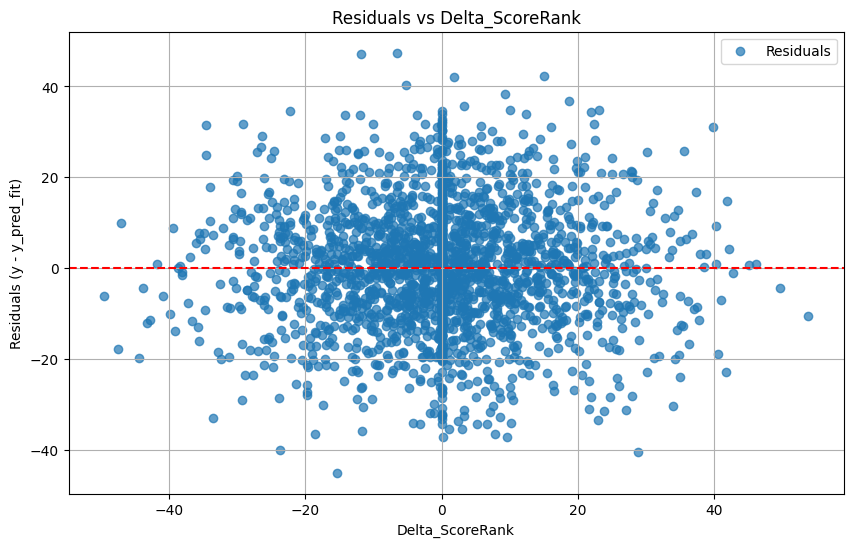

Delta_ScoreRank Segment (-50, -40]: MSE = 130.8965
Delta_ScoreRank Segment (-40, -30]: MSE = 181.2997
Delta_ScoreRank Segment (-30, -20]: MSE = 184.1624
Delta_ScoreRank Segment (-20, -10]: MSE = 184.0834
Delta_ScoreRank Segment (-10, 0]: MSE = 162.8063
Delta_ScoreRank Segment (0, 10]: MSE = 194.0406
Delta_ScoreRank Segment (10, 20]: MSE = 175.0761
Delta_ScoreRank Segment (20, 30]: MSE = 215.1722
Delta_ScoreRank Segment (30, 40]: MSE = 198.6613


In [49]:
# Sample dataframe (replace with your actual data)
delta_scorerank = filtered_played['Impact']

df = pd.DataFrame({
    'y': y,
    'y_pred_fit': y_pred_fit,
    'Delta_ScoreRank': delta_scorerank
})

# Calculate residuals
df['Residuals'] = df['y'] - df['y_pred_fit']

# Define the bins for Delta_ScoreRank (-0.5 to 0.5 with step size of 0.1)
bins = np.arange(-50, 50, 10)  # end at 0.6 to include 0.5 in the last interval
df['Delta_ScoreRank_bin'] = pd.cut(df['Delta_ScoreRank'], bins)

# Calculate the MSE for each bin
mse_results = df.groupby('Delta_ScoreRank_bin').apply(
    lambda group: mean_squared_error(group['y'], group['y_pred_fit'])
)

# Plotting the residuals vs Delta_ScoreRank
plt.figure(figsize=(10, 6))
plt.scatter(df['Delta_ScoreRank'], df['Residuals'], alpha=0.7, label='Residuals')
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Delta_ScoreRank')
plt.ylabel('Residuals (y - y_pred_fit)')
plt.title('Residuals vs Delta_ScoreRank')
plt.legend()
plt.grid(True)
plt.show()

# Display the MSE for each segment
for segment, mse in mse_results.items():
    print(f"Delta_ScoreRank Segment {segment}: MSE = {mse:.4f}")
